<a href="https://colab.research.google.com/github/ShawnLiu119/Recommendation_ML_CB-CF-Hyb/blob/main/Recommendation_CB_CF_Hyb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Overview all regular recommendation system approach - CB/CF/Hybrid**

### **Term** <br>
**content based** should give you pretty safe recommendations. However, they may bound to what you already know your customers like.

**collaborative filtering approach** recommends items liked by customers whose choice is similar to yours

**cold start** for that particular customer or that particular item, meaning that you could not educatedly predict someone without knowing even a thing of that person: a **knowledge-based approach** would do the job to find out something of the newcomers by you **sending out questionnaire** to collect their personal preference with their consent.

**Recommendation strategy is dependent on how much you know your customers**

data summary<br>

 It contains events that a **customer view / add-to-cart / purchase an item**[INTERACTION], and the category hierarchy for each of the items. The ~235000 items are categorized in ~1300 categories and these categories are further grouped into some ~400 parent categories.
 https://medium.com/analytics-vidhya/content-based-collaborative-and-their-hybrid-approaches-for-recommendation-making-to-e-commence-e2015830a04f

Reference:https://github.com/recommenders-team/recommenders

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/kaggle_data/retail_recom'

category_tree = pd.read_csv(path + '/category_tree.csv')
events = pd.read_csv(path + '/events.csv')
item_properties_1 = pd.read_csv(path + '/item_properties_part1.csv')
item_properties_2 = pd.read_csv(path + '/item_properties_part2.csv')

### EDA

In [4]:
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [5]:
category_tree.groupby('parentid').size().sort_values(ascending=False).head(10)

parentid
250.0     31
1009.0    22
362.0     22
351.0     19
1259.0    18
1687.0    17
945.0     15
312.0     15
92.0      13
1482.0    13
dtype: int64

In [6]:
events.event.value_counts()

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

In [7]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [8]:
events[events.transactionid.notnull()]['event'].value_counts()
#Transaction ID will only have value if the user made a purchase as shown below

event
transaction    22457
Name: count, dtype: int64

In [9]:
item_properties_1.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


Item id will be the unique item identifier <br>
Property is the Item's attributes such as category id and availability while the rest are hashed for confidentiality purposes<br>
Value is the item's property value e.g. availability is 1 if there is stock and 0 otherwise<br>
Values that start with "n" indicate that the value preceeding it is a number e.g. n277.200 is equal to 277.2

In [10]:
item = pd.concat([item_properties_1, item_properties_2])
item.shape

(20275902, 4)

In [11]:
#transform timestamp into time

def convert_timestamp(df, column):
    df['datetime'] = pd.to_datetime(df[column], unit='ms')
    return df

convert_timestamp(events, 'timestamp')
convert_timestamp(item, 'timestamp')

,timestamp,itemid,property,value,datetime
0,1435460400000,460429,categoryid,1338,2015-06-28 03:00:00
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,2015-08-09 03:00:00
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00
4,1431831600000,156781,917,828513,2015-05-17 03:00:00
...,...,...,...,...,...
9275898,1433646000000,236931,929,n12.000,2015-06-07 03:00:00
9275899,1440903600000,455746,6,150169 639134,2015-08-30 03:00:00
9275900,1439694000000,347565,686,610834,2015-08-16 03:00:00
9275901,1433646000000,287231,867,769062,2015-06-07 03:00:00


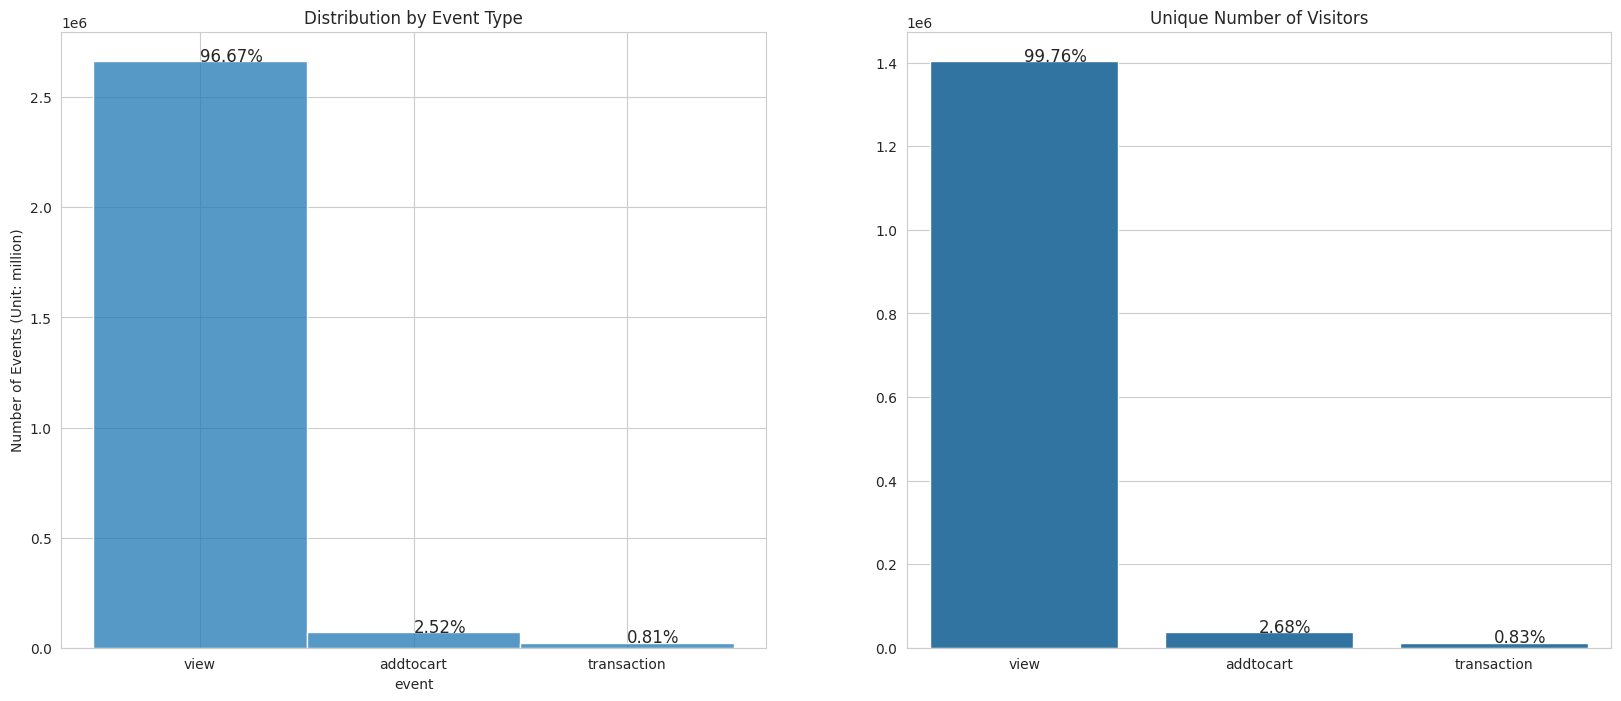

In [12]:
sns.set_style('whitegrid')

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))
sns.histplot(x = 'event', data = events, bins = 3, ax = ax1)
totalcases = len(events)

ax1.set_ylabel('Number of Events (Unit: million)')
ax1.set_title('Distribution by Event Type')
for x, counts in zip(events['event'].unique().tolist(), events['event'].value_counts().tolist()): #index and value to list
    text=str(round((counts/totalcases)*100,2)) +'%'
    ax1.text(x, counts, text, fontsize=12)


# unique number of visitors by event

event_list = events['event'].unique().tolist()
unique_num = []
ratios = []
for e in event_list:
    uni_visit = events['visitorid'][events['event']==e].nunique()
    unique_num.append(uni_visit)
    ratios.append(uni_visit/events['visitorid'].nunique())

sns.barplot(x = event_list, y = unique_num, ax = ax2)

ratio_p = [str(round(r*100,2)) + '%' for r in ratios]
for e, c, r in zip(range(3), unique_num, ratio_p): #label with x y cooridinate
    ax2.text(e, c, r, fontsize=12)

ax2.set_title('Unique Number of Visitors')
plt.show()

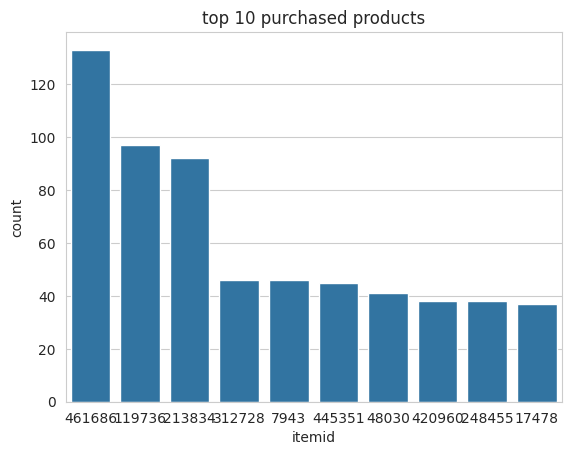

<Figure size 1000x600 with 0 Axes>

In [13]:
#top purchased products

top10 = pd.DataFrame(events[events['event']=='transaction'].groupby('itemid').size().sort_values(ascending=False).head(10).rename('count')).reset_index()
sns.barplot(top10, x='itemid', y='count', order=top10.sort_values('count', ascending=False).itemid)
plt.title('top 10 purchased products')
plt.figure(figsize=(10,6))
plt.show()

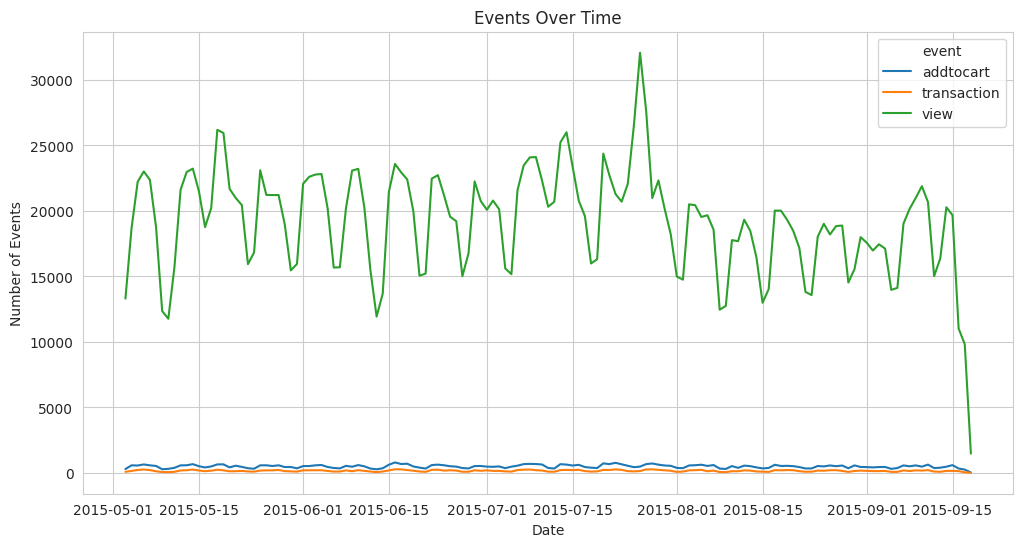

In [14]:
#time series


events['date'] = events['datetime'].dt.date
event_daily = events.groupby(['date', 'event']).size().reset_index().rename(columns={0:'count'})
plt.figure(figsize=(12, 6))
sns.lineplot(data=event_daily, x='date', y='count', hue='event')
plt.title('Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.show()